In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt

import train
import util
import preprocess as p

'''Set parameters'''
torch.manual_seed(1) # set the random seed
use_cuda = True # Use cuda
batch_size = 128
num_workers = 0

'''Check GPU'''
print(torch.cuda.get_device_name(torch.cuda.current_device()))

GeForce RTX 2060 SUPER


#### Preprocess and save New Data
This includes:
- CK data
- Collected data from Google images

In [2]:
ck_df = p.get_CK_df()
ck_count = [0, 0, 0, 0, 0, 0, 0]
p.save_ck_as_tensors(ck_df, '../ProcessedData/CK/', ck_count, cutoff=75)

Finished saving to ../ProcessedData/CK/
[75, 0, 75, 75, 75, 75, 0]


In [5]:
collected_df = p.get_collected_df()
collected_count = [0, 0, 0, 0, 0, 0, 0]
p.save_ck_as_tensors(collected_df, '../ProcessedData/CollectedData/', collected_count, cutoff=75)

Finished saving to ../ProcessedData/CollectedData/
[12, 0, 12, 12, 12, 12, 12]


#### Load CK data and Collected Data

In [6]:
#load tensors
ck_path = '../ProcessedData/CK'
ck_dataset = torchvision.datasets.DatasetFolder(ck_path, loader=torch.load, extensions=('.tensor'))
ck_loader = torch.utils.data.DataLoader(ck_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

ck_dataset

Dataset DatasetFolder
    Number of datapoints: 750
    Root location: ../ProcessedData/CK

In [2]:
#load tensors
collected_path = '../ProcessedData/CollectedData'
collected_dataset = torchvision.datasets.DatasetFolder(collected_path, loader=torch.load, extensions=('.tensor'))
collected_loader = torch.utils.data.DataLoader(collected_dataset, batch_size=1, num_workers=num_workers, shuffle=True)

collected_dataset

Dataset DatasetFolder
    Number of datapoints: 72
    Root location: ../ProcessedData/CollectedData

#### Load other test data

In [8]:
#load tensors
fer_test_path = '../ProcessedData/Testing/FER_test'
mux_test_path = '../ProcessedData/Testing/Mux_test'
kdef_test_path = '../ProcessedData/Testing/KDEF_test'
master_path = '../ProcessedData/combined/'

fer_test_dataset = torchvision.datasets.DatasetFolder(fer_test_path, loader=torch.load, extensions=('.tensor'))
fer_test_loader = torch.utils.data.DataLoader(fer_test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

mux_test_dataset = torchvision.datasets.DatasetFolder(mux_test_path, loader=torch.load, extensions=('.tensor'))
mux_test_loader = torch.utils.data.DataLoader(mux_test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

kdef_test_dataset = torchvision.datasets.DatasetFolder(kdef_test_path, loader=torch.load, extensions=('.tensor'))
kdef_test_loader = torch.utils.data.DataLoader(kdef_test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

test_dataset = torchvision.datasets.DatasetFolder(master_path + 'test', loader=torch.load, extensions=('.tensor'))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

#### Load Checkpoint

In [7]:
# Model definition
resnet50 = models.resnet50(pretrained=True).cuda()
num_ftrs = resnet50.fc.in_features
resnet50.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1000),
    nn.ReLU(True),
    nn.Dropout(0.4),
    nn.Linear(1000, 50),
    nn.ReLU(True),
    nn.Dropout(0.4),
    nn.Linear(50, 6)
)
resnet50.fc = resnet50.fc.cuda()
resnet50.cuda()

# Load
# Other Checkpoint names:

checkpoint_path1 = '../torch_checkpoints/model_Resnet50-Pretrained-12000-Dropout_bs32_lr0_0001_epoch5.pt'
checkpoint_path2 = '../torch_checkpoints/model_Resnet50-Pretrained-12000-Dropout_bs128_lr0_001_epoch5.pt'
checkpoint_path3 = '../torch_checkpoints/model_Resnet50-Pretrained-12000-Dropout_bs128_lr0_001_epoch5-58-FER.pt'

#### Get accuracy on CK

In [10]:
# Model 1
print("Model 1： ")
resnet50.load_state_dict(torch.load(checkpoint_path1))
print('CK: ' + str(train.get_accuracy(resnet50, ck_loader)))
print('FER: ' + str(train.get_accuracy(resnet50, fer_test_loader)))
print('Mux: ' + str(train.get_accuracy(resnet50, mux_test_loader)))
print('KDEF: ' + str(train.get_accuracy(resnet50, kdef_test_loader)))
print('Collected: ' + str(train.get_accuracy(resnet50, collected_loader)))
print('Combined: ' + str(train.get_accuracy(resnet50, test_loader)))

# Model 2
print("Model 2： ")
resnet50.load_state_dict(torch.load(checkpoint_path2))
print('CK: ' + str(train.get_accuracy(resnet50, ck_loader)))
print('FER: ' + str(train.get_accuracy(resnet50, fer_test_loader)))
print('Mux: ' + str(train.get_accuracy(resnet50, mux_test_loader)))
print('KDEF: ' + str(train.get_accuracy(resnet50, kdef_test_loader)))
print('Collected: ' + str(train.get_accuracy(resnet50, collected_loader)))
print('Combined: ' + str(train.get_accuracy(resnet50, test_loader)))

# Model 1
print("Model 3： ")
resnet50.load_state_dict(torch.load(checkpoint_path3))
print('CK: ' + str(train.get_accuracy(resnet50, ck_loader)))
print('FER: ' + str(train.get_accuracy(resnet50, fer_test_loader)))
print('Mux: ' + str(train.get_accuracy(resnet50, mux_test_loader)))
print('KDEF: ' + str(train.get_accuracy(resnet50, kdef_test_loader)))
print('Collected: ' + str(train.get_accuracy(resnet50, collected_loader)))
print('Combined: ' + str(train.get_accuracy(resnet50, test_loader)))

Model 1： 
CK: 0.664
FER: 0.5716440422322775
Mux: 0.7876543209876543
KDEF: 0.753968253968254
Collected: 0.5972222222222222
Combined: 0.6373426754898145
Model 2： 
CK: 0.6986666666666667
FER: 0.573340874811463
Mux: 0.7945679012345679
KDEF: 0.7724867724867724
Collected: 0.6111111111111112
Combined: 0.6412352406902816
Model 3： 
CK: 0.6706666666666666
FER: 0.5865384615384616
Mux: 0.7866666666666666
KDEF: 0.7857142857142857
Collected: 0.6527777777777778
Combined: 0.6488906189178669


#### Accuracy on Each Class

In [11]:
print(train.get_class_accuracy(resnet50, test_loader))
print(train.get_class_accuracy(resnet50, fer_test_loader))
print(train.get_class_accuracy(resnet50, mux_test_loader))
print(train.get_class_accuracy(resnet50, kdef_test_loader))
print(train.get_class_accuracy(resnet50, ck_loader))
print(train.get_class_accuracy(resnet50, collected_loader))

[0.498 0.386 0.789 0.503 0.704 0.717]
[0.471 0.367 0.773 0.489 0.73  0.592]
[0.421 0.    0.804 0.561 0.357 0.822]
[0.857 0.651 0.937 0.667 0.762 0.841]
[0.111 0.107 1.    0.512 0.924 0.   ]
[0.75  0.25  1.    0.333 0.833 0.75 ]


#### Confusion Matrix

In [12]:
# FER
print(train.compute_confusion_matrix(resnet50, fer_test_loader))

          Anger  Fear  Happy  Sad  Surprise  Neutral
Anger       350    69     40  131        23      130
Fear         88   282     29  172        78      120
Happy        56    26   1043   71        47      106
Sad          74   115     35  446         9      233
Surprise     16    68     27   14       439       37
Neutral      49    60     66  180        24      551


In [13]:
# Mux
print(train.compute_confusion_matrix(resnet50, mux_test_loader))

          Anger  Fear  Happy  Sad  Surprise  Neutral
Anger        16     1      5    2         3       11
Fear          1     0      0    1         1        1
Happy         6     3    687   19        11      129
Sad           0     2      2   23         0       14
Surprise      3     3      4    1        20       25
Neutral      33    13     49   68        21      847


In [14]:
# KDEF
print(train.compute_confusion_matrix(resnet50, kdef_test_loader))

          Anger  Fear  Happy  Sad  Surprise  Neutral
Anger        54     0      0    5         0        4
Fear          1    41      3    6         6        6
Happy         0     1     59    0         0        3
Sad          13     1      0   42         0        7
Surprise      0    14      0    0        48        1
Neutral       3     1      0    6         0       53


In [15]:
# Combined
print(train.compute_confusion_matrix(resnet50, test_loader))

          Anger  Fear  Happy  Sad  Surprise  Neutral
Anger       420    70     45  138        26      145
Fear         90   323     32  179        85      127
Happy        62    30   1789   90        58      238
Sad          87   118     37  511         9      254
Surprise     19    85     31   15       507       63
Neutral      85    74    115  254        45     1451


In [16]:
# CK
print(train.compute_confusion_matrix(resnet50, ck_loader))

          Anger  Fear  Happy  Sad  Surprise  Neutral
Anger        15     8      0   61         3       48
Fear          0     8     28   11        10       18
Happy         0     0    207    0         0        0
Sad          10     3      0   43         0       28
Surprise      0     3      2    1       230       13
Neutral       0     0      0    0         0        0


In [17]:
# Collected
print(train.compute_confusion_matrix(resnet50, collected_loader))

          Anger  Fear  Happy  Sad  Surprise  Neutral
Anger         9     0      0    0         0        3
Fear          0     3      1    2         4        2
Happy         0     0     12    0         0        0
Sad           1     2      0    4         0        5
Surprise      0     2      0    0        10        0
Neutral       0     1      0    2         0        9


1 for correct, 0 for incorrect prediction n [[0 1 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 1]
 [0 0 0 0 0 0]
 [0 1 1 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 1 0]
 [0 0 0 1 0 0]
 [0 0 0 0 0 1]
 [1 0 0 0 0 0]
 [0 1 1 0 0 0]]


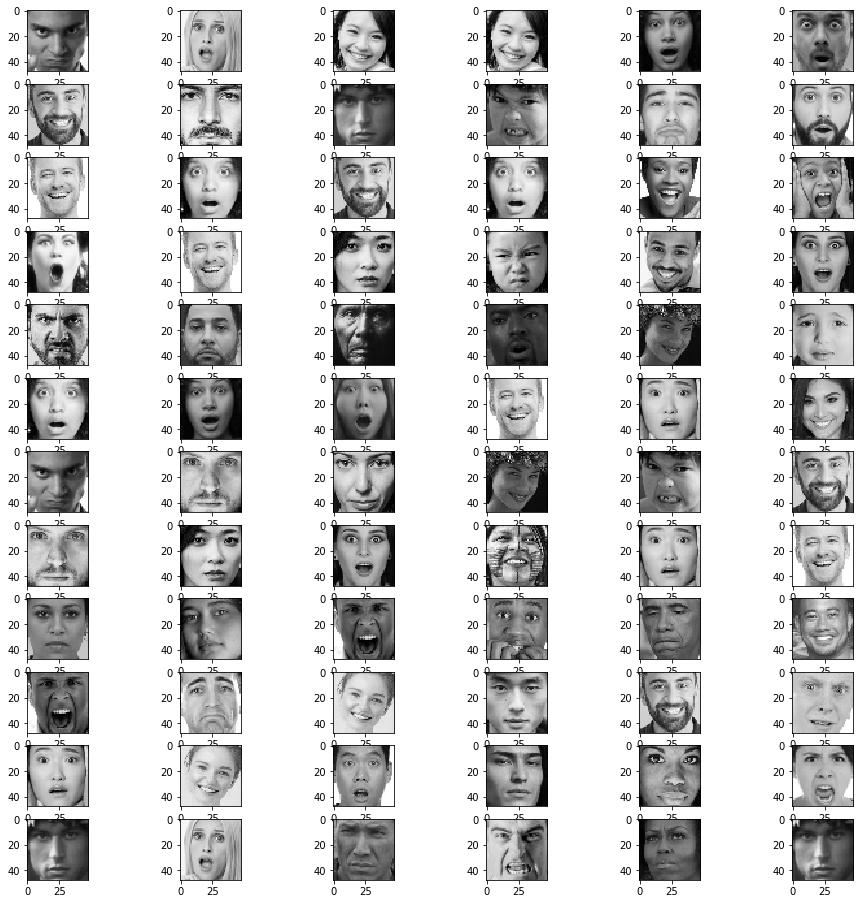

In [13]:
resnet50.load_state_dict(torch.load(checkpoint_path2))

import math

fig = plt.figure(figsize=(16, 16))
columns = 6
rows = 12
correct_array = np.zeros((rows, columns), dtype=int)

for i in range(0, columns * rows):
    
    imgs, labels = iter(collected_loader).next()

    if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()

    imgs = imgs.float()       # Convert to float from double

    # model will be whatever your loaded last
    output = resnet50(imgs)
    output = output.max(1, keepdim=True)[1]

    # calculate the images
    img = imgs[0]
    img_np = np.asarray((img.cpu().transpose(0,1)).transpose(1,2))
    plt.subplot(rows, columns, i + 1) 

    # calculate the correctness matrix
    row = math.floor(i / 6)
    column = i % 6
    correct_array[row, column] = output[0].eq(labels.view_as(output[0])).sum().item()

    # plot the image
    plt.imshow(img_np)
# show the correctness matrix
print('1 for correct, 0 for incorrect prediction: \n {}'.format(correct_array))